In [1]:
import numpy as np
import trimesh as tri
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os import listdir

from utils import lddmm_utils, mesh_processing

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Random resampling unit sphere

In [2]:
mesh = tri.creation.uv_sphere()
mesh

<trimesh.Trimesh(vertices.shape=(2016, 3), faces.shape=(3780, 3))>

In [3]:
sampled = tri.sample.sample_surface_even(mesh, 16*16)
param = tri.convex.convex_hull(sampled[0])

In [4]:
sampled = tri.sample.sample_surface(mesh, 16*16)
reparam = tri.convex.convex_hull(sampled[0])

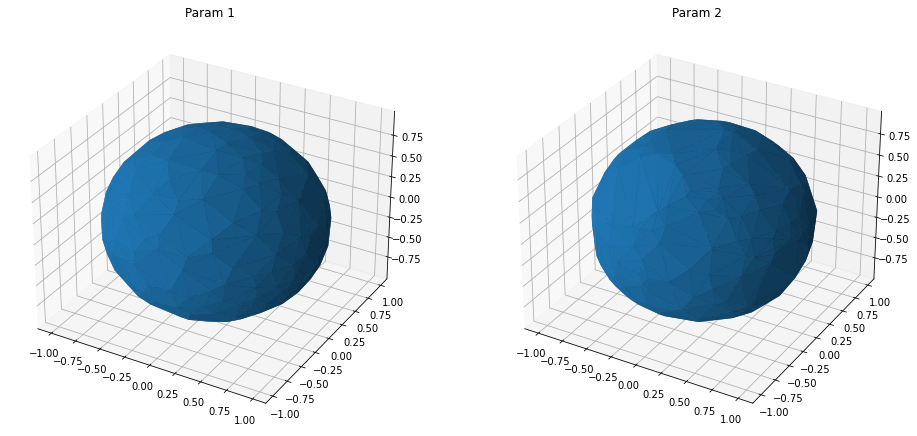

In [5]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Param 1")
ax2 = fig.add_subplot(122, projection='3d')
ax1.plot_trisurf(param.vertices[:, 0], param.vertices[:,1], triangles=param.faces, Z=param.vertices[:,2])
ax2.plot_trisurf(reparam.vertices[:, 0], reparam.vertices[:,1], triangles=reparam.faces, Z=reparam.vertices[:,2]) 
ax2.set_title("Param 2")
plt.show()

## Non linear function from the sphere

In [6]:
def f(x,y,z):
    return np.array([x+y, y**2, z*y]).T

In [7]:
res = f(np.array(param.vertices)[:, 0], np.array(param.vertices)[:, 1], np.array(param.vertices)[:, 2])
res_reparam = f(np.array(reparam.vertices)[:, 0], np.array(reparam.vertices)[:, 1], np.array(reparam.vertices)[:, 2])

In [8]:
mesh = tri.Trimesh(vertices=res,
                       faces=param.faces)
mesh_reparam = tri.Trimesh(vertices=res_reparam,
                       faces=reparam.faces)

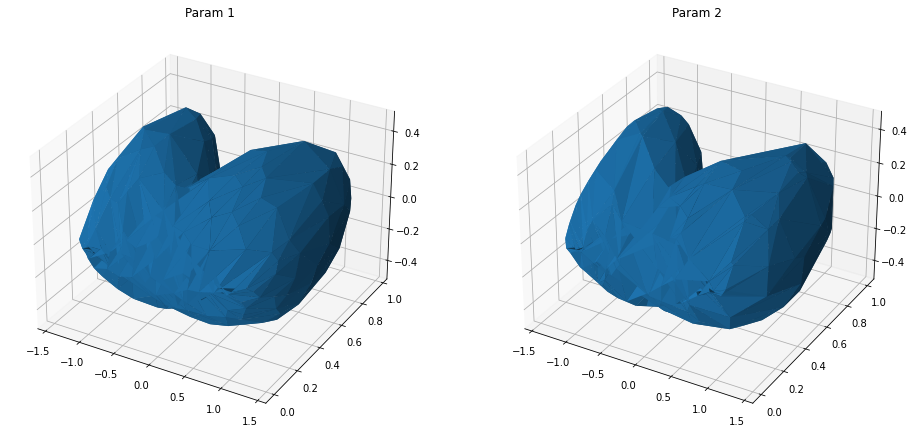

In [9]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2])
ax1.set_title("Param 1")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(mesh_reparam.vertices[:, 0], mesh_reparam.vertices[:,1], triangles=mesh_reparam.faces, Z=mesh_reparam.vertices[:,2])
ax2.set_title("Param 2")

plt.show()

## Define distances

In [10]:
# torch type and device

def varifold_dist(mesh1, mesh2, sigma):
    
    use_cuda = torch.cuda.is_available()
    torchdeviceId = torch.device("cuda:0") if use_cuda else "cpu"
    torchdtype = torch.float32

    # PyKeOps counterpart
    KeOpsdeviceId = torchdeviceId.index  # id of Gpu device (in case Gpu is  used)
    KeOpsdtype = torchdtype.__str__().split(".")[1]  # 'float32'
    
    V1, F1 = np.array(mesh1.vertices), np.array(mesh1.faces)
    V2, F2 = np.array(mesh2.vertices), np.array(mesh2.faces)
    
    q0 = torch.from_numpy(V1).clone().detach().to(dtype=torchdtype, device=torchdeviceId).requires_grad_(True)
    VT = torch.from_numpy(V2).clone().detach().to(dtype=torchdtype, device=torchdeviceId)
    FS = torch.from_numpy(F1).clone().detach().to(dtype=torch.long, device=torchdeviceId)
    FT = torch.from_numpy(F2).clone().detach().to(dtype=torch.long, device=torchdeviceId)
    sigma = torch.tensor([sigma], dtype=torchdtype, device=torchdeviceId)
    
    p0 = torch.zeros(q0.shape, dtype=torchdtype, device=torchdeviceId, requires_grad=True)
    dataloss = lddmm_utils.lossVarifoldSurf(FS, VT, FT, lddmm_utils.GaussLinKernel(sigma=sigma))
    Kv = lddmm_utils.GaussKernel(sigma=sigma)
    loss = lddmm_utils.LDDMMloss(Kv, dataloss)

    dist = loss(p0, q0)

    return(dist)

In [11]:
varifold_dist(param, reparam, sigma = 1)

tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)

### Test on 1 expression

In [13]:
COMA1 = tri.load_mesh('data/bareteeth.000001_COMA_id1.ply')
COMA2 = tri.load_mesh('data/bareteeth.000001_COMA_id2.ply')

FLAME1 = tri.load_mesh('data/bareteeth.000001_FLAME_id1.ply')
FLAME2 = tri.load_mesh('data/bareteeth.000001_FLAME_id2.ply')

sigma = 0.6

In [14]:
#SIG = np.linspace(0.0001,0.2,50)
#dist_inter = np.array([varifold_dist(COMA1, COMA2, sigma).item() for sigma in SIG])
#dist_intra = np.array([varifold_dist(COMA1, FLAME1, sigma).item() for sigma in SIG])

In [15]:
#plt.plot(SIG, dist_inter, c = 'r', label = "Dist entre 2 identités")
#plt.plot(SIG, dist_intra, c = 'b', label = "Dist entre 2 params")
#plt.legend(loc = "upper left")
#plt.show()

In [16]:
d2 = np.linalg.norm(np.array(COMA1.vertices) - np.array(COMA2.vertices))
print(d2)

0.33371855031458575


In [17]:
flame1 = ["data/FLAME_id1_expr1/" + path for path in listdir("data/FLAME_id1_expr1") if "ply" in path]
coma1 = ["data/COMA_id1_expr1/" + path for path in listdir("data/COMA_id1_expr1") if "ply" in path]
flame2 = ["data/FLAME_id2_expr1/" + path for path in listdir("data/FLAME_id2_expr1") if "ply" in path]
coma2 = ["data/COMA_id2_expr1/" + path for path in listdir("data/COMA_id2_expr1") if "ply" in path]
flame3 = ["data/FLAME_id3_expr1/" + path for path in listdir("data/FLAME_id3_expr1") if "ply" in path]
coma3 = ["data/COMA_id3_expr1/" + path for path in listdir("data/COMA_id3_expr1") if "ply" in path]

In [102]:
sigmas = np.linspace(0.0001,0.2, 20)
sigma = 0.1

diff_coma = []
diff_coma_l2 = []
diff_flame = []
diff_flame_l2 = []
for sigma in sigmas:
    dist_var = []
    dist_l2 = []
    for i in range(np.min([len(coma1), len(coma2)])):
        mesh1, mesh2 = tri.load_mesh(coma1[i]), tri.load_mesh(coma2[i])
    
        dist_var.append(varifold_dist(mesh1,mesh2, sigma).item())
        dist_l2.append(np.linalg.norm(np.array(mesh1.vertices) - np.array(mesh2.vertices)))
    
    diff_coma.append(np.mean(dist_var))
    diff_coma_l2.append(np.mean(dist_l2))
diff_coma = np.array(diff_coma)
diff_coma_l2 = np.array(diff_coma_l2)

for sigma in sigmas:
    dist_var = []
    dist_l2 = []
    for i in range(np.min([len(coma1), len(flame2)])):
        mesh1, mesh2 = tri.load_mesh(coma1[i]), tri.load_mesh(flame2[i])
    
        dist_var.append(varifold_dist(mesh1,mesh2, sigma).item())
        dist_l2.append(np.linalg.norm(np.array(mesh1.vertices) - np.array(mesh2.vertices)))
    
    diff_flame.append(np.mean(dist_var))
    diff_flame_l2.append(np.mean(dist_l2))
diff_flame = np.array(diff_flame)
diff_flame_l2 = np.array(diff_flame_l2)

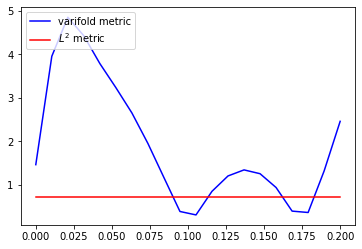

In [103]:
Y = np.abs(diff_coma - diff_flame)/diff_coma * 100
Y2 = np.abs(diff_coma_l2 - diff_flame_l2)/diff_coma_l2 * 100

plt.plot(sigmas,Y, 'b', label='varifold metric')
plt.plot(sigmas,Y2, 'r', label ='$L^2$ metric')
plt.legend(loc = 'upper left') 

In [78]:
dist_var = []
dist_l2 = []

for i in range(np.min([len(coma1), len(coma2)])):
    mesh1, mesh2 = tri.load_mesh(coma1[i]), tri.load_mesh(coma2[i])
    
    dist_var.append(varifold_dist(mesh1,mesh2,sigma).item())
    dist_l2.append(np.linalg.norm(np.array(mesh1.vertices) - np.array(mesh2.vertices)))

In [79]:
print(np.mean(dist_l2))
print(np.mean(dist_var))

0.44299112025191284
5.260857896090628e-05


In [80]:
(0.4429 - 0.0923)/0.4429 * 100

79.16008128245655

In [81]:
(5.2608 - 0.6289)/5.2608 * 100

88.04554440389295

In [82]:
dist_var = []
dist_l2 = []

for i in range(np.min([len(flame1), len(flame2)])):
    mesh1, mesh2 = tri.load_mesh(flame1[i]), tri.load_mesh(flame2[i])
    
    dist_var.append(varifold_dist(mesh1,mesh2,sigma).item())
    dist_l2.append(np.linalg.norm(np.array(mesh1.vertices) - np.array(mesh2.vertices)))
    
print(np.mean(dist_l2))
print(np.mean(dist_var))

### Random ellipsoid databases

In [12]:
from numpy import random

sphere = tri.creation.uv_sphere(count=[64, 64])
points, faces = tri.sample.sample_surface_even(sphere, count = 16*16)

transfo = np.array([[4*random.random() + 1,0,0],
                        [0,4*random.random() + 1,0],
                        [0,0,4*random.random() + 1]])
ell = transfo.dot(points.T).T

param = tri.convex.convex_hull(ell)

(-5.0, 5.0)

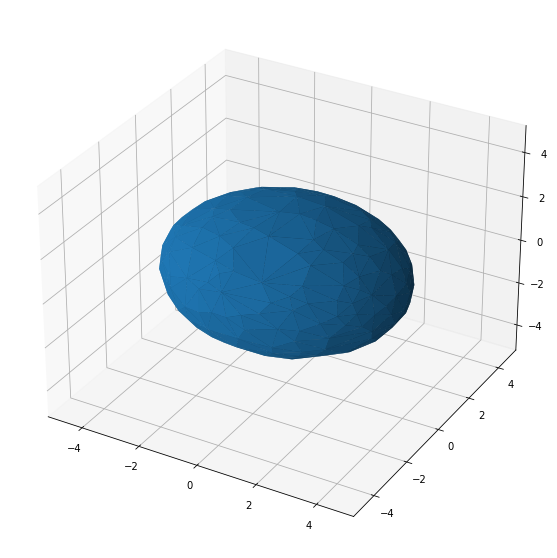

In [13]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(param.vertices[:,0], param.vertices[:,1], triangles = param.faces, Z=param.vertices[:,2])
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_zlim(-5,5)

In [14]:
M = 1000
base = []
transformations = []

sphere = tri.creation.uv_sphere(count=[64, 64])
points, faces = tri.sample.sample_surface_even(sphere, count = 16*16)
sphere_sample = tri.convex.convex_hull(points)

for m in range(M):

    transfo = np.array([[4*random.random() + 1,0,0],
                        [0,4*random.random() + 1,0],
                        [0,0,4*random.random() + 1]])
    
    transformations.append(transfo)
    ell = transfo.dot(points.T).T
    param = tri.convex.convex_hull(ell)
    base.append(param)
    
base = np.array(base)
transformations = np.array(transformations)

In [15]:
alpha, beta, gamma = 0.123, -1.234, 2.345

origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]

Rx = tri.transformations.rotation_matrix(alpha, xaxis)
Ry = tri.transformations.rotation_matrix(beta, yaxis)
Rz = tri.transformations.rotation_matrix(gamma, zaxis)

R = tri.transformations.concatenate_matrices(Rx, Ry, Rz)

In [16]:
new_sphere = sphere_sample.apply_transform(R)
new_points = new_sphere.vertices

In [17]:
new_base = []

for m in range(M):

    transfo = transformations[m]
    
    ell = transfo.dot(new_points.T).T
    param = tri.Trimesh(vertices = ell, faces = new_sphere.faces)
    #param = tri.convex.convex_hull(ell)
    new_base.append(param)
    
new_base = np.array(new_base)

### Test

(-5.0, 5.0)

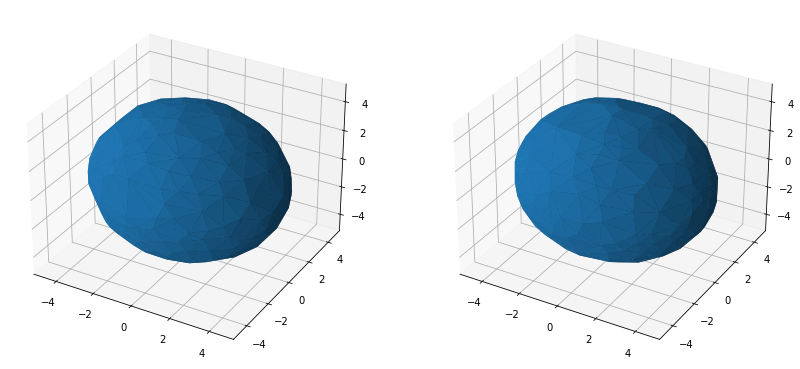

In [18]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(base[1].vertices[:,0], base[1].vertices[:,1], triangles = base[1].faces, Z=base[1].vertices[:,2])
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_zlim(-5,5)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(new_base[1].vertices[:,0], new_base[1].vertices[:,1], triangles = new_base[1].faces, Z=new_base[1].vertices[:,2])
ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)
ax2.set_zlim(-5,5)

In [19]:
sphere = tri.creation.uv_sphere(count=[64, 64])

In [20]:
mean = sphere.area_faces.mean()

In [21]:
lst = [sphere.area_faces[i] + 6*mean for i in range(len(sphere.area_faces)//2)] + [sphere.area_faces[i] for i in range(len(sphere.area_faces)//2, len(sphere.area_faces))]
face_weights = np.array(lst)

In [22]:
points, faces = tri.sample.sample_surface(sphere, count = 16*16, face_weight=face_weights)
bad_mesh = tri.convex.convex_hull(points)

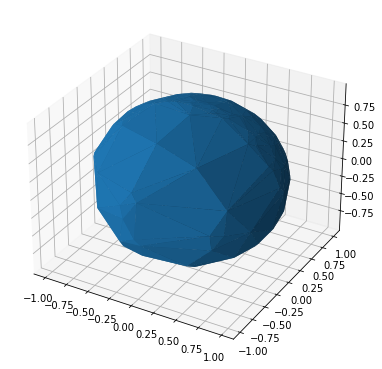

In [23]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(bad_mesh.vertices[:,0], bad_mesh.vertices[:,1], triangles = bad_mesh.faces, Z=bad_mesh.vertices[:,2])

In [24]:
bad_sphere = bad_mesh
bad_points = bad_sphere.vertices

In [25]:
bad_base = []

for m in range(M):

    transfo = transformations[m]
    
    ell = transfo.dot(bad_points.T).T
    param = tri.convex.convex_hull(ell)
    bad_base.append(param)
    
bad_base = np.array(bad_base)

(-4.0, 4.0)

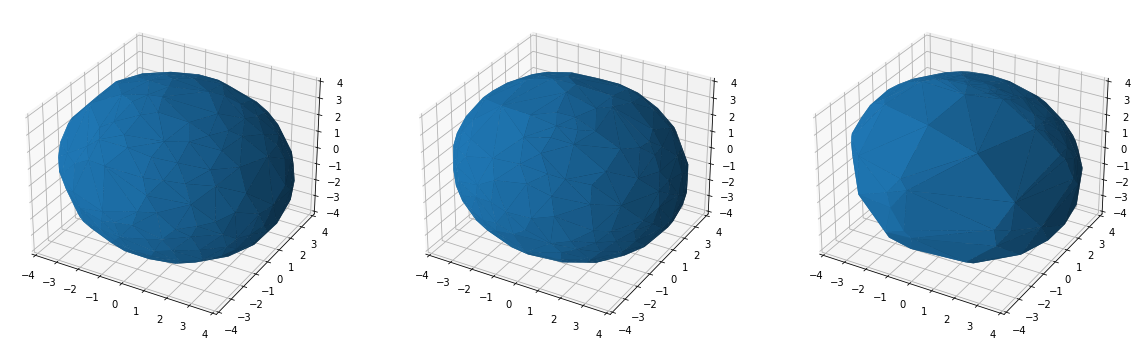

In [28]:
l = 4
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_trisurf(base[1].vertices[:,0], base[1].vertices[:,1], triangles = base[1].faces, Z=base[1].vertices[:,2])
ax1.set_xlim(-l,l)
ax1.set_ylim(-l,l)
ax1.set_zlim(-l,l)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_trisurf(new_base[1].vertices[:,0], new_base[1].vertices[:,1], triangles = new_base[1].faces, Z=new_base[1].vertices[:,2])
ax2.set_xlim(-l,l)
ax2.set_ylim(-l,l)
ax2.set_zlim(-l,l)

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_trisurf(bad_base[1].vertices[:,0], bad_base[1].vertices[:,1], triangles = bad_base[1].faces, Z=bad_base[1].vertices[:,2])
ax3.set_xlim(-l,l)
ax3.set_ylim(-l,l)
ax3.set_zlim(-l,l)

In [53]:
base[1].faces

TrackedArray([[249,  48,  83],
              [ 64,   0,  62],
              [220,  34,  37],
              ...,
              [ 92, 137,  54],
              [ 74,  13,  54],
              [ 54, 223,  74]])

In [51]:
new_sphere.faces

TrackedArray([[249,  48,  83],
              [ 64,   0,  62],
              [220,  34,  37],
              ...,
              [ 92, 137,  54],
              [ 74,  13,  54],
              [ 54, 223,  74]])

In [52]:
sphere_sample.faces

TrackedArray([[249,  48,  83],
              [ 64,   0,  62],
              [220,  34,  37],
              ...,
              [ 92, 137,  54],
              [ 74,  13,  54],
              [ 54, 223,  74]])

### Export .ply

In [57]:
import os

In [58]:
if not os.path.exists("data"):
    os.mkdir("data")

if not os.path.exists("data/artificial_database"):
    os.mkdir("data/artificial_database")
    
if not os.path.exists("data/artificial_database/ref_base"):
    os.mkdir("data/artificial_database/ref_base")
    
if not os.path.exists("data/artificial_database/reparam_base"):
    os.mkdir("data/artificial_database/reparam_base")

if not os.path.exists("data/artificial_database/bad_reparam_base"):
    os.mkdir("data/artificial_database/bad_reparam_base")

In [59]:
dr = "data/artificial_database/ref_base/"

for f in os.listdir(dr):
    os.remove(os.path.join(dr, f))
    
for i, mesh in enumerate(base):
    mesh_processing.export_mesh(mesh.vertices, mesh.faces, "data/artificial_database/ref_base/" + str(i) + ".ply")

In [60]:
dr = "data/artificial_database/reparam_base/"

for f in os.listdir(dr):
    os.remove(os.path.join(dr, f))
    
for i, mesh in enumerate(new_base):
    mesh_processing.export_mesh(mesh.vertices, mesh.faces, "data/artificial_database/reparam_base/" + str(i) + ".ply")

In [61]:
dr = "data/artificial_database/bad_reparam_base/"

for f in os.listdir(dr):
    os.remove(os.path.join(dr, f))

for i, mesh in enumerate(bad_base):
    mesh_processing.export_mesh(mesh.vertices, mesh.faces, "data/artificial_database/bad_reparam_base/" + str(i) + ".ply")

In [62]:
mesh_processing.export_mesh(sphere_sample.vertices, sphere_sample.faces,
                            "data/artificial_database/" + "template.ply")